Fetching 1 year of weather and AQI data for karachi

In [3]:


import requests
import json
from datetime import datetime, timedelta
import time

# Configuration
AQI_API_KEY = "6f5bd489ac2182623da65e8c0210a0d3"  # AQI API key
WEATHER_API_KEY = "a8b5181c2df94da6943114229252201"  # WeatherAPI key
CITY = "Karachi"
# Geocoding URL to get latitude and longitude
GEO_URL = f"http://api.openweathermap.org/geo/1.0/direct?q={CITY}&limit=1&appid={AQI_API_KEY}"

# Function to fetch coordinates
def fetch_coordinates():
    while True:
        response = requests.get(GEO_URL)
        if response.status_code == 200:
            data = response.json()
            if data:
                return data[0]['lat'], data[0]['lon']
            else:
                raise Exception("City not found.")
        elif response.status_code == 429:  # Too Many Requests
            retry_after = int(response.headers.get("Retry-After", 60))  # Default to 60 seconds
            print(f"Rate limit hit. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        else:
            raise Exception(f"Failed to fetch coordinates: {response.status_code}")

# Historical Weather and AQI URL
def fetch_historical_data(lat, lon, timestamp):
    # AQI data URL
    AQI_URL = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={timestamp}&end={timestamp+3600}&appid={AQI_API_KEY}"
    # Weather data URL (WeatherAPI)
    WEATHER_URL = f"http://api.weatherapi.com/v1/history.json?key={WEATHER_API_KEY}&q={lat},{lon}&dt={datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')}"
    
    while True:
        # Fetch AQI data
        aqi_response = requests.get(AQI_URL)
        weather_response = requests.get(WEATHER_URL)

        if aqi_response.status_code == 200 and weather_response.status_code == 200:
            aqi_data = aqi_response.json()
            weather_data = weather_response.json()
            return {
                "aqi": aqi_data,
                "weather": weather_data
            }
        elif aqi_response.status_code == 429 or weather_response.status_code == 429:  # Too Many Requests
            retry_after = int(aqi_response.headers.get("Retry-After", 60))  # Default to 60 seconds
            print(f"Rate limit hit for timestamp {timestamp}. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        else:
            print(f"Failed to fetch data for timestamp {timestamp}: AQI - {aqi_response.status_code}, Weather - {weather_response.status_code}")
            return None

# Fetch coordinates
try:
    latitude, longitude = fetch_coordinates()
except Exception as e:
    print(f"Error fetching coordinates: {e}")
    exit(1)

# Backfill data for the past 1 year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
data = []

current_date = start_date
while current_date <= end_date:
    timestamp = int(current_date.timestamp())
    historical_data = fetch_historical_data(latitude, longitude, timestamp)
    if historical_data:
        data.append(historical_data)
    current_date += timedelta(hours=1)  # Increment by 1 hour

# Save the backfilled data
with open("historical_aqi_and_weather_data.json", "w") as f:
    json.dump(data, f)

print("Historical AQI and weather data fetched and saved successfully.")


C:\Users\huzai\AppData\Local\Temp\ipykernel_6196\2312946794.py:35: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  WEATHER_URL = f"http://api.weatherapi.com/v1/history.json?key={WEATHER_API_KEY}&q={lat},{lon}&dt={datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')}"


Historical AQI and weather data fetched and saved successfully.


Feature Engineering and making a csv

In [14]:
import pandas as pd
from datetime import datetime, timezone

# Load historical data
with open("historical_aqi_and_weather_data.json", "r") as f:
    data = json.load(f)

# Preprocess the data and compute features
def preprocess_data(data):
    processed_data = []
    for entry in data:
        # Extract AQI data
        aqi_list = entry['aqi']['list']
        if not aqi_list:
            continue  # Skip if no AQI data is available
        main_aqi = aqi_list[0]['main']['aqi']
        components = aqi_list[0]['components']

        # Extract weather data
        weather = entry['weather']['forecast']['forecastday'][0]['day']
        dt = datetime.fromtimestamp(aqi_list[0]['dt'], tz=timezone.utc)  # Use timezone-aware datetime

        # Create a processed entry
        processed_entry = {
            "timestamp": aqi_list[0]['dt'],
            "year": dt.year,
            "month": dt.month,
            "day": dt.day,
            "hour": dt.hour,
            "weekday": dt.weekday(),
            "aqi": main_aqi,
            "co": components.get("co"),
            "no": components.get("no"),
            "no2": components.get("no2"),
            "o3": components.get("o3"),
            "so2": components.get("so2"),
            "pm2_5": components.get("pm2_5"),
            "pm10": components.get("pm10"),
            "nh3": components.get("nh3"),
            "temperature": weather["avgtemp_c"],  # Average temperature from WeatherAPI
            "humidity": weather["avghumidity"],   # Average humidity from WeatherAPI
            "wind_speed": weather["maxwind_kph"], # Max wind speed from WeatherAPI
            "precipitation": weather["totalprecip_mm"],  # Total precipitation from WeatherAPI
        }
        processed_data.append(processed_entry)
    return pd.DataFrame(processed_data)

# Load and preprocess the data
df = preprocess_data(data)

# Compute derived features (e.g., AQI change rate)
df['aqi_change_rate'] = df['aqi'].diff()  # Change rate of AQI
df['aqi_rolling_avg'] = df['aqi'].rolling(window=24).mean()  # 24-hour rolling average

# Add season
df['season'] = df['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else
                                           'spring' if x in [3, 4, 5] else
                                           'summer' if x in [6, 7, 8] else
                                           'fall')

# Add is_weekend
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Add time_of_day
df['time_of_day'] = df['hour'].apply(lambda x: 'morning' if 6 <= x < 12 else
                                               'afternoon' if 12 <= x < 18 else
                                               'evening' if 18 <= x < 24 else
                                               'night')

# Add AQI lag features
df['aqi_lag_1'] = df['aqi'].shift(1)  # AQI from the previous hour
df['aqi_lag_24'] = df['aqi'].shift(24)  # AQI from the previous day
df['aqi_lag_168'] = df['aqi'].shift(168)  # AQI from the previous week

# Add pollutant lag features
for pollutant in ['co', 'no2', 'pm2_5', 'pm10']:
    df[f'{pollutant}_lag_1'] = df[pollutant].shift(1)  # Lag 1 hour
    df[f'{pollutant}_lag_24'] = df[pollutant].shift(24)  # Lag 1 day

# Rolling statistics for AQI
df['aqi_rolling_std'] = df['aqi'].rolling(window=24).std()  # 24-hour rolling standard deviation
df['aqi_rolling_min'] = df['aqi'].rolling(window=24).min()  # 24-hour rolling minimum
df['aqi_rolling_max'] = df['aqi'].rolling(window=24).max()  # 24-hour rolling maximum

# Rolling statistics for pollutants
for pollutant in ['co', 'no2', 'pm2_5', 'pm10']:
    df[f'{pollutant}_rolling_avg'] = df[pollutant].rolling(window=24).mean()
    df[f'{pollutant}_rolling_std'] = df[pollutant].rolling(window=24).std()

# Change rates for pollutants
for pollutant in ['co', 'no2', 'pm2_5', 'pm10']:
    df[f'{pollutant}_change_rate'] = df[pollutant].diff()

# Change rates for weather variables
for weather_var in ['temperature', 'humidity', 'wind_speed']:
    df[f'{weather_var}_change_rate'] = df[weather_var].diff()

# Interaction features
df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
df['wind_pm2_5_interaction'] = df['wind_speed'] * df['pm2_5']

# Cumulative features
df['cumulative_precipitation'] = df['precipitation'].rolling(window=24).sum()
for pollutant in ['co', 'no2', 'pm2_5', 'pm10']:
    df[f'cumulative_{pollutant}'] = df[pollutant].rolling(window=24).sum()

# Binary features
df['high_pollution_alert'] = df['aqi'].apply(lambda x: 1 if x > 150 else 0)  # Threshold = 150
df['rain_alert'] = df['precipitation'].apply(lambda x: 1 if x > 0 else 0)

# Polynomial features
df['temperature_squared'] = df['temperature'] ** 2
df['humidity_squared'] = df['humidity'] ** 2

# Save the preprocessed data to a CSV file
df.to_csv('preprocessed_data.csv', index=False)
print("Preprocessed data saved to 'preprocessed_data.csv'.")

Preprocessed data saved to 'preprocessed_data.csv'.


Using the csv as the feature store.

EDA feature Importance

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8641 entries, 0 to 8640
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  8641 non-null   int64  
 1   year                       8641 non-null   int64  
 2   month                      8641 non-null   int64  
 3   day                        8641 non-null   int64  
 4   hour                       8641 non-null   int64  
 5   weekday                    8641 non-null   int64  
 6   aqi                        8641 non-null   int64  
 7   co                         8641 non-null   float64
 8   no                         8641 non-null   float64
 9   no2                        8641 non-null   float64
 10  o3                         8641 non-null   float64
 11  so2                        8641 non-null   float64
 12  pm2_5                      8641 non-null   float64
 13  pm10                       8641 n

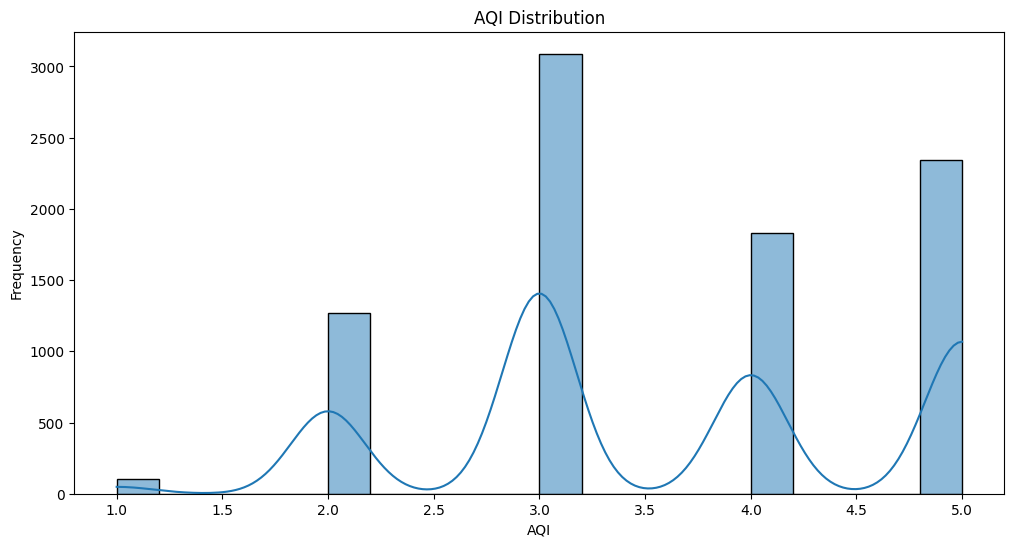

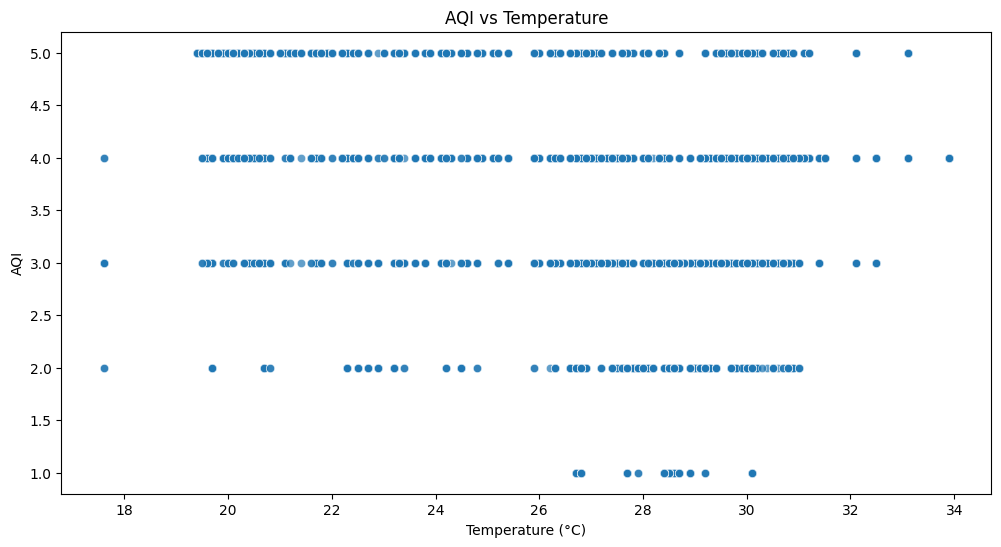

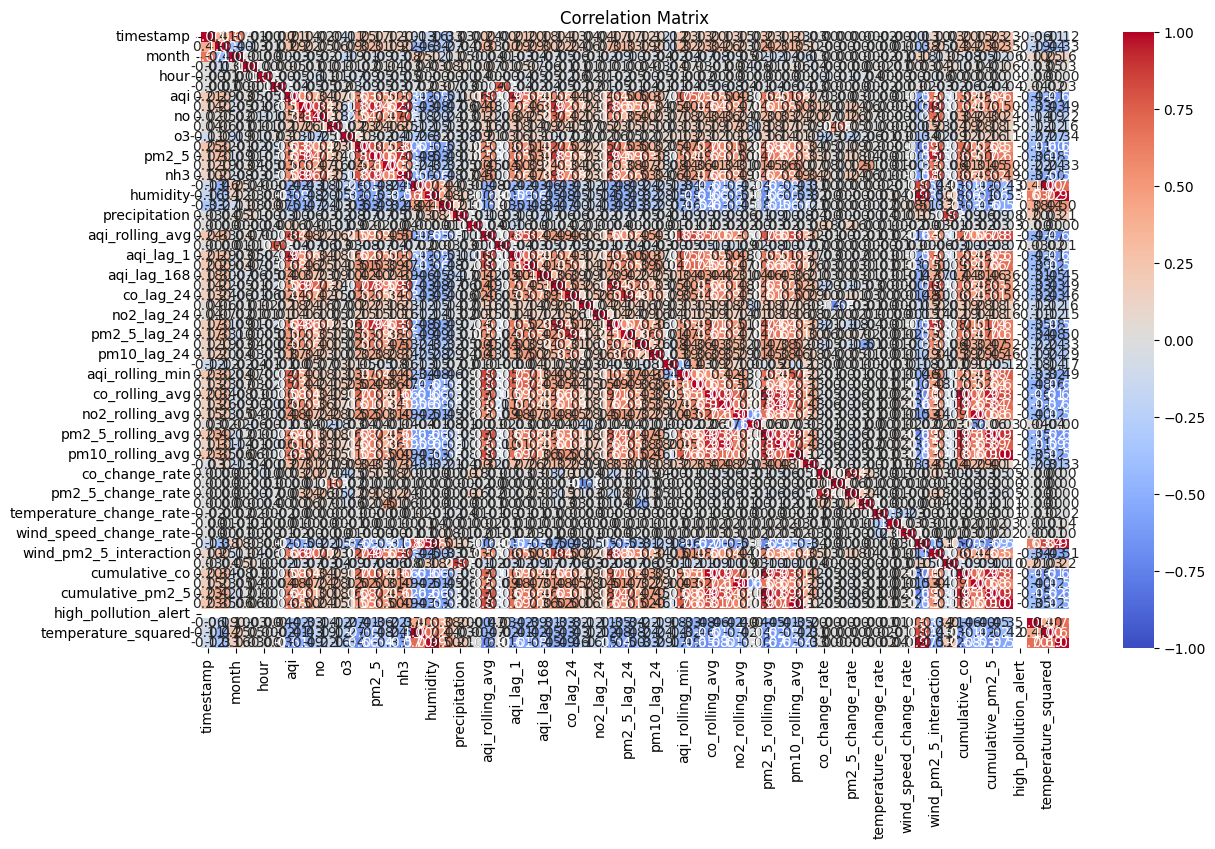

Processed data saved to 'processed_data.csv'.
Random Forest - RMSE: 0.025240314040497317
Random Forest - MAE: 0.001717755928282242
Random Forest - R²: 0.9994588649280198
Top 10 Important Features:
             Feature  Importance
11              pm10    0.727710
22         aqi_lag_1    0.137434
10             pm2_5    0.110595
17   aqi_change_rate    0.015073
8                 o3    0.008603
31        pm10_lag_1    0.000152
47  pm10_change_rate    0.000084
18   aqi_rolling_avg    0.000075
34   aqi_rolling_min    0.000042
42  pm10_rolling_avg    0.000030


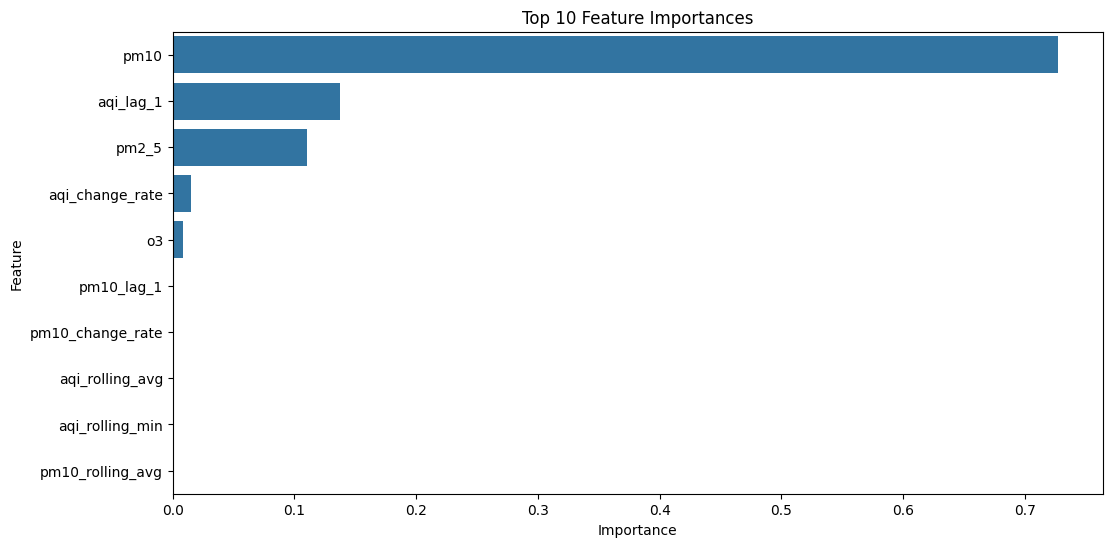

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# --- Step 1: Load Data from CSV ---
# Load the preprocessed data from the CSV file
csv_file = "preprocessed_data.csv"  # Replace with your CSV file
features_df = pd.read_csv(csv_file)

# Quick overview of the data
print("Data Overview:")
print(features_df.info())
print(features_df.describe())

# --- Step 2: EDA (Exploratory Data Analysis) ---
# Univariate Analysis: Distribution of AQI
plt.figure(figsize=(12, 6))
sns.histplot(features_df["aqi"], bins=20, kde=True)
plt.title("AQI Distribution")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

# Bivariate Analysis: AQI vs Temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=features_df, x="temperature", y="aqi", alpha=0.7)
plt.title("AQI vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("AQI")
plt.show()

# Correlation Matrix
numeric_features_df = features_df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 8))
correlation_matrix = numeric_features_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# --- Step 3: Feature Engineering ---
# Prepare the data
X = features_df.drop(columns=["aqi", "timestamp"])  # Drop target and non-feature columns
y = features_df["aqi"]

# Handle missing values separately for numeric and non-numeric columns
numeric_columns = X.select_dtypes(include=["number"]).columns
non_numeric_columns = X.select_dtypes(exclude=["number"]).columns

# Fill missing values for numeric columns with their mean
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())

# Fill missing values for non-numeric columns with a placeholder
X[non_numeric_columns] = X[non_numeric_columns].fillna("Unknown")

# Label Encoding for categorical data
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Save processed data (optional)
processed_data = pd.concat([X, y], axis=1)
processed_data.to_csv("processed_data.csv", index=False)
print("Processed data saved to 'processed_data.csv'.")

# --- Step 4: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 5: Train Random Forest for Feature Importance ---
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print(f"Random Forest - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"Random Forest - MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Random Forest - R²: {r2_score(y_test, y_pred)}")

# --- Step 6: Feature Importance ---
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Top 10 Important Features:")
print(feature_importances.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances.head(10))
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Training ML models

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import lightgbm as lgb
import joblib
import os

# --- Step 1: Load Preprocessed Data ---
# Load the processed data from the CSV file
file_path = "processed_data.csv"
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=["aqi"])  # Drop target and non-feature columns
y = data["aqi"]

# Handle missing values separately for numeric and non-numeric columns
numeric_columns = X.select_dtypes(include=["number"]).columns
non_numeric_columns = X.select_dtypes(exclude=["number"]).columns

# Fill missing values for numeric columns with their mean
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())

# Fill missing values for non-numeric columns with a placeholder
X[non_numeric_columns] = X[non_numeric_columns].fillna("Unknown")

# Label Encoding for categorical data
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 2: Define Evaluation Function ---
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return rmse, mae, r2

# --- Step 3: Initialize Models ---
# Dictionary of models to evaluate
models = {
    "random_forest": RandomForestRegressor(random_state=42),
    "ridge_regression": Ridge(alpha=1.0),
    "xgboost": XGBRegressor(random_state=42),
    "lightgbm": lgb.LGBMRegressor(random_state=42),
}

# Dictionary to store the performance of each model
model_performance = {}

# --- Step 4: Train and Evaluate Models ---
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)  # Train the model
    rmse, mae, r2 = evaluate_model(model, X_test, y_test)  # Evaluate the model
    model_performance[model_name] = {"rmse": rmse, "mae": mae, "r2": r2}  # Store performance
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# --- Step 5: Train and Evaluate Advanced Models (Optional) ---
# TensorFlow (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a simple neural network
tf_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
tf_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
print("Training TensorFlow model...")
history = tf_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_tf = tf_model.predict(X_test).flatten()
rmse_tf = np.sqrt(mean_squared_error(y_test, y_pred_tf))
mae_tf = mean_absolute_error(y_test, y_pred_tf)
r2_tf = r2_score(y_test, y_pred_tf)
model_performance["tensorflow"] = {"rmse": rmse_tf, "mae": mae_tf, "r2": r2_tf}
print(f"TensorFlow - RMSE: {rmse_tf}, MAE: {mae_tf}, R²: {r2_tf}")

# --- Step 6: Compare Model Performance ---
# Create a comparison table
results_df = pd.DataFrame(model_performance).T
print("Model Comparison:")
print(results_df)

# --- Step 7: Identify the Best Model ---
# Identify the best model based on R² score
best_model_name = max(model_performance, key=lambda x: model_performance[x]["r2"])
best_model_r2 = model_performance[best_model_name]["r2"]

print(f"Best model: {best_model_name} with R²: {best_model_r2}")

# --- Step 8: Retrain the Best Model on the Entire Dataset ---
print(f"Retraining {best_model_name} on the entire dataset...")

# Combine training and testing data
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Retrain the best model on the full dataset
if best_model_name == "random_forest":
    best_model = RandomForestRegressor(random_state=42)
elif best_model_name == "ridge_regression":
    best_model = Ridge(alpha=1.0)
elif best_model_name == "xgboost":
    best_model = XGBRegressor(random_state=42)
elif best_model_name == "lightgbm":
    best_model = lgb.LGBMRegressor(random_state=42)
elif best_model_name == "tensorflow":
    best_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    best_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the best model on the full dataset
if best_model_name in ["random_forest", "ridge_regression", "xgboost", "lightgbm"]:
    best_model.fit(X_full, y_full)
elif best_model_name == "tensorflow":
    best_model.fit(X_full, y_full, epochs=50, batch_size=32, verbose=1)

# --- Step 9: Save the Retrained Model to the Model Registry ---
# Create a directory for the model registry
model_registry_dir = "model_registry"
os.makedirs(model_registry_dir, exist_ok=True)

# Save the retrained model
retrained_model_file = os.path.join(model_registry_dir, f"{best_model_name}_retrained.pkl")
if best_model_name in ["random_forest", "ridge_regression", "xgboost", "lightgbm"]:
    joblib.dump(best_model, retrained_model_file)
elif best_model_name == "tensorflow":
    best_model.save(retrained_model_file)

print(f"Retrained {best_model_name} model saved to {retrained_model_file}.")

Training random_forest...
random_forest - RMSE: 0.025240314040497317, MAE: 0.001717755928282242, R²: 0.9994588649280198
Training ridge_regression...
ridge_regression - RMSE: 0.0006693118125259812, MAE: 0.0004945490873951326, R²: 0.9999996194837977
Training xgboost...
xgboost - RMSE: 0.04367437550714612, MAE: 0.002943586241378475, R²: 0.9983797669410706
Training lightgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10030
[LightGBM] [Info] Number of data points in the train set: 6912, number of used features: 61
[LightGBM] [Info] Start training from score 3.580295
lightgbm - RMSE: 0.041137509747845045, MAE: 0.011003216066306819, R²: 0.9985625519088146
Training TensorFlow model...
Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 388964.3750 - mae: 271.6530 - val_loss: 9122.0547 - val_mae: 57.7671
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7951.2324 - mae: 56.9429 - val_loss: 3816.6677 - val_mae: 37.6342
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5004.4717 - mae: 44.6526 - val_loss: 5286.9087 - val_mae: 46.8163
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3327.9270 - mae: 35.7958 - val_loss: 1291.3424 - val_mae: 21.1899
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1357.2213 - mae: 22.5358 - val_loss: 2176.5339 - val_mae: 32.6925
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2271.9194 - mae: 26.9458 - val_loss: 939.6202 - val_mae: 17.5894
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1245.0061 - mae: 20.2447 - val_loss: 1493.6927 - val_mae: 26.7901
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1133.6969 - mae: 19.4314 - val_loss: 671.0219 - val_mae: 13.0551
Ep